In [186]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u
from copy import deepcopy

from R_load import R_val

from multiprocessing import Pool
import emcee

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

corrections = np.loadtxt('ps1_calspec_cor.txt')
calsources = pd.read_csv('../calibration/calspec_full.csv')

In [106]:
cra = calsources.ra.values
cdec = calsources.dec.values
dist = calsources.gaia_med.values
coords = SkyCoord(cra*u.deg,cdec*u.deg,
                  distance=dist*u.pc, frame='icrs')
bayestar = BayestarQuery()
Calmed = bayestar(coords, mode='median')


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 37.019 s
  pix_info:   0.529 s
   samples:  23.886 s
      best:   4.905 s
       nan:   0.393 s
      sort:   7.122 s
       idx:   0.183 s


In [110]:
syn = np.load('current_caspec_mags.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)

good = []
for i in range(len(syn['name'])):
    if 'ngc6681' not in syn['name'].iloc[i]:
        good += [i]
good = np.array(good)
syn = syn.iloc[good]
gr = syn['g'].values-syn['r'].values
ind = (gr < 1) #& (gr >= 0.2)
syn = syn.iloc[ind]
calmed = Calmed[good][ind]

In [257]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux
    

def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/z)**c[3]
    return fit 

def r_comp(c,mag,ext=0,R_var=False):
    zp = 25
    gr = ext*(mag['g'] - mag['r'])
    if R_var:
        ge = ext * R_val('g',gr=gr,ext=ext)[0]
        re = ext * R_val('r',gr=gr,ext=ext)[0]
        ie = ext * R_val('i',gr=gr,ext=ext)[0]
        ze = ext * R_val('z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 # 
        re = ext * 2.611# 2.617 # 
        ie = ext * 1.935# 1.971 # 
        ze = ext * 1.523# 1.549 # 
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r


def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    fit = (0.5*g + 0.5*i)*(g/i)**c[0]+re
    return fit 

def r_minimizer(c,mag,ext=None):
    k = mag['r']
    fit = r_comp(c,mag,ext=ext)
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

# emcee

def chi2(var,data,ex=0):
    real = mag2flux(data['r'])
    fit = r_comp(var,data,ext=ex)
    fit = mag2flux(fit)
    fit = np.log(fit)
    real = np.log(real)
    residual = np.nansum(((fit-real)**2/real))
    return -(residual) 

def flat_prior(var):
    g = var[0]
    i = var[1]
    z = var[2]
    colour = var[3]
    if (0 <= g) & (0 <= i) & (0 <= z) & ((g+i+z) < 1):
        #print(g+i+z)
        return 0.0
    return -np.inf

def probability(var, data,ex=0):
    lp = flat_prior(var)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2(var,data,ex=ex)

In [181]:
c0 = [.0305,1,0.0132,0.3558]
bds = [(0,2),(0,2),(0,2),(-100,100)]
res = minimize(r_minimizer,c0,args=(syn,calmed),bounds=bds)

/Users/rridden/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [178]:
c0 = [.0305]
bds = [(-100,100)]
res = minimize(chi2,c0,args=(syn,calmed))

In [239]:
res

      fun: 0.3586380468723007
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.40818315, 2.31829541, 2.23158949, 0.97220134])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 685
      nit: 32
     njev: 137
   status: 0
  success: True
        x: array([0.05219065, 0.99862204, 0.        , 0.31264066])

In [183]:
test = r_comp(res.x,syn,ext=calmed)
#test = r_comp(mc,syn)
rdiff = syn['r']-test
gr = syn['g'].values-syn['r'].values
ri = syn['r'].values-syn['i'].values
control = (syn['r']-syn['i']).values
mask = ~sigma_clip(rdiff).mask
rdiff = rdiff[mask]

<IPython.core.display.Javascript object>


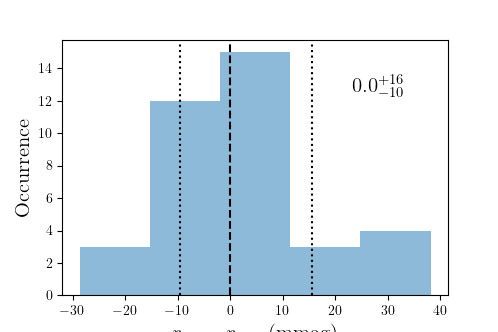

In [187]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(rdiff) - np.nanmin(rdiff) /(2*iqr(rdiff)*len(rdiff)**(-1/3)))
plt.hist(rdiff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(rdiff*1e3,50)
low = np.percentile(rdiff*1e3,16)
high = np.percentile(rdiff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str((np.round(med,0)))+'^{+' + str(int(np.round(high-med,0)))+'}_{'+str(int(np.round(low-med,0)))+'}$'
plt.annotate(s,(.75,.8),fontsize=15,xycoords='axes fraction')

plt.xlabel(r'$r_{cal}-r_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('PS1_com_r_res.pdf', bbox_inches = "tight")

In [312]:
obs = pd.read_csv('K2_all_PS1_psc_ev_crowding_sdss_gaia.csv')
#obs = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev_crowding.csv')


obs = obs.iloc[(obs['PDC'].values > 0)]

obs['kMeanPSFMag'] = -2.5*np.log10(obs['PDC'].values)
obs['kMeanPSFMagErr'] = 0.01#(-2.5 / np.log(10)) * (obs['PDCe'].values / obs['PDC'].values) #0.05#np.abs(obs['PDCe'].values) / np.abs(obs['PDC'].values)/10
#obs = obs.iloc[abs(obs['kMeanPSFMagErr'].values) < 0.1] 
diff = abs(obs['rMeanPSFMag'].values - obs['crMeanPSFMag'].values)
ind = diff < 1
obs = obs.iloc[ind]
ind = (obs['gMeanPSFMag'].values - obs['rMeanPSFMag'].values) < 0.9
data = obs.iloc[ind]


ind = ((abs(data['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['iMeanPSFMagErr'].values) < 0.5))
data = data.iloc[ind]

data['gMeanPSFMag'] = data['gMeanPSFMag'].values - corrections[0]
data['rMeanPSFMag'] = data['rMeanPSFMag'].values - corrections[1] 
data['iMeanPSFMag'] = data['iMeanPSFMag'].values - corrections[2]
data['zMeanPSFMag'] = data['zMeanPSFMag'].values - corrections[3]

cind =  ((data['campaign'].values == 16))
c16 = data.iloc[cind]

cind =  ((data['campaign'].values == 4))
c4 = data.iloc[cind]

In [313]:
g = data['gMeanPSFMag'].values
r = data['rMeanPSFMag'].values
i = data['iMeanPSFMag'].values
z = data['zMeanPSFMag'].values


dist = deepcopy(data)
obs = {'g':g,'r':r,'i':i,'z':z}

g = c16['gMeanPSFMag'].values
r = c16['rMeanPSFMag'].values
i = c16['iMeanPSFMag'].values
z = c16['zMeanPSFMag'].values


d16 = deepcopy(c16)
c16 = {'g':g,'r':r,'i':i,'z':z}

g = c4['gMeanPSFMag'].values
r = c4['rMeanPSFMag'].values
i = c4['iMeanPSFMag'].values
z = c4['zMeanPSFMag'].values

d4 = deepcopy(c4)
c4 = {'g':g,'r':r,'i':i,'z':z}

In [432]:
bayestar = BayestarQuery(max_samples=1)
coords = SkyCoord(dist.RAJ2000.values*u.deg,dist.DecJ2000.values*u.deg,
                  distance=dist.gaia_med.values*u.pc, frame='icrs')
medall = bayestar(coords)#, mode='median')

coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg,
                  distance=d16.gaia_low.values*u.pc, frame='icrs')
med16 = bayestar(coords)#, mode='median')

coords = SkyCoord(d4.RAJ2000.values*u.deg,d4.DecJ2000.values*u.deg,
                  distance=d4.gaia_high.values*u.pc, frame='icrs')
med4 = bayestar(coords)#, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.228 s
  pix_info:   0.536 s
   samples:   5.636 s
      best:   5.107 s
       nan:   0.041 s
      sort:   7.747 s
       idx:   0.160 s


In [380]:
des

array([11.504619, 11.504619, 11.504619, ..., 11.504619, 11.504619,
       11.504619])

In [404]:
dists = np.arange(0,6e3)
ras = np.zeros_like(dists)
ras[:] = d16.RAJ2000.values[0]
des = np.zeros_like(dists)
des[:] = d16.DecJ2000.values[0]
coords = SkyCoord(ras*u.deg,des*u.deg,
                  distance=dists*u.pc, frame='icrs')
test = bayestar(coords, mode='random_sample')

/Users/rridden/miniconda3/lib/python3.7/site-packages/dustmaps/bayestar.py:436: RuntimeWarning: divide by zero encountered in log10
  dm = 5. * (np.log10(d) + 2.)


<IPython.core.display.Javascript object>


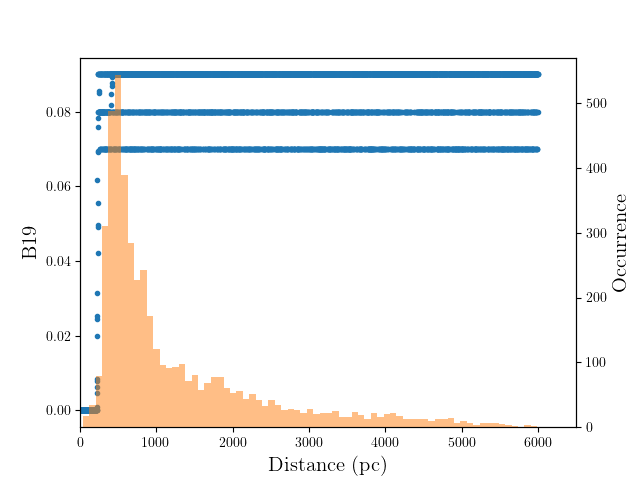

In [405]:
plt.figure()
plt.plot(dists,test,'.',label='B19 coeff')
plt.ylabel('B19',fontsize=15)
plt.xlabel('Distance (pc)',fontsize=15)
plt.xlim(0,6500)
ax2 = plt.gca().twinx()
plt.hist(d16.gaia_low.values,bins=100,color='C1',alpha=0.5,label='Gaia median distance');
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('b19_vs_gaia_c16.png')

In [375]:
d16_chan = np.zeros(84)
for i in range(84):
    ind = d16.Channel.values == i
    d16_chan[i] = np.nanmedian(med16[ind])

/Users/rridden/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [376]:
d16_chan

array([       nan, 0.03      , 0.03      , 0.04      , 0.04      ,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.03      , 0.03      ,
       0.04      , 0.035     ,        nan,        nan,        nan,
              nan, 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02      , 0.03      , 0.02      , 0.03      , 0.06      ,
       0.035     , 0.05      , 0.05      , 0.04      , 0.03      ,
       0.04      , 0.05      , 0.02      , 0.02      , 0.03      ,
       0.04      , 0.03      , 0.02      , 0.01      , 0.02      ,
       0.02      , 0.02      , 0.05      , 0.04      , 0.04      ,
       0.04      , 0.04      , 0.04      , 0.05      , 0.03      ,
       0.04      , 0.04      , 0.04      , 0.03      , 0.035     ,
       0.05      , 0.03      , 0.03      , 0.03      , 0.04      ,
       0.055     , 0.04      , 0.035     , 0.04      , 0.05      ,
       0.04577993, 0.03      , 0.03      , 0.04      , 0.04   

In [366]:
coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg, frame='icrs')
med16 = np.nanmedian(bayestar(coords, mode='median'),axis=1)

coords = SkyCoord(d4.RAJ2000.values*u.deg,d4.DecJ2000.values*u.deg, frame='icrs')
med4 = np.nanmedian(bayestar(coords, mode='median'),axis=1)

In [355]:
med16.shape

(4787,)

<IPython.core.display.Javascript object>


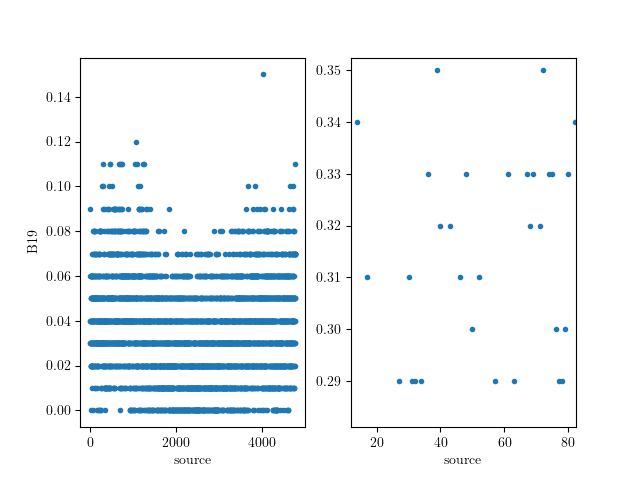

Text(0.5, 0, 'source')

In [369]:
plt.figure()
plt.subplot(121)
plt.plot(med16,'.')
plt.ylabel('B19')
plt.xlabel('source')

plt.subplot(122)
plt.plot(med4,'.')
plt.xlabel('source')

In [335]:
np.(d16.gaia_med.values)

1398.915420610369

<IPython.core.display.Javascript object>


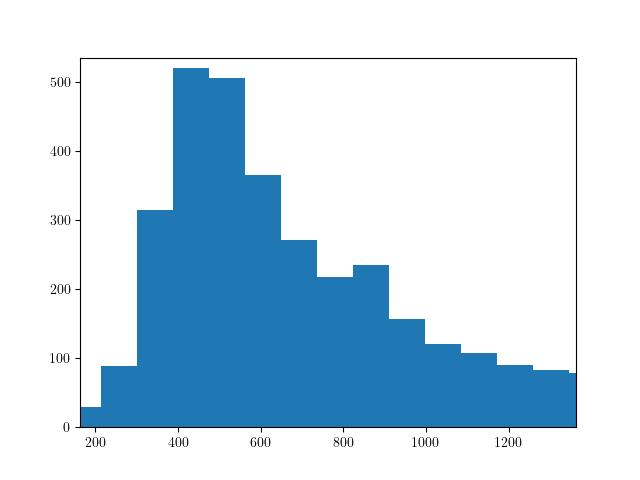

(array([ 18.,  30.,  89., 315., 521., 506., 366., 272., 218., 235., 157.,
        120., 108.,  90.,  83.,  79.,  84.,  72.,  75.,  47.,  65.,  77.,
         62.,  47.,  53.,  50.,  48.,  40.,  40.,  44.,  31.,  30.,  36.,
         26.,  21.,  26.,  21.,  25.,  16.,  20.,  20.,  17.,  23.,  16.,
         20.,  23.,  14.,  14.,  21.,  15.,  13.,  16.,  15.,  19.,  12.,
         16.,  13.,  11.,  11.,  13.,  11.,   6.,  13.,  14.,  16.,   1.,
          6.,   5.,   7.,   4.,   7.,   4.,   4.,   5.,   2.,   2.,   3.,
          3.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  38.15291674,  125.41783108,  212.68274542,  299.94765976,
         387.2125741 ,  474.47748844,  561.74240278,  649.00731712,
         736.27223146,  823.5371458 ,  910.80206014,  998.06697448,
        1085.33188882, 1172.59680316, 1259.8617175 , 1347.12663184,
        1434.39154618, 1521.65646052, 1608.921

In [336]:
plt.figure()
plt.hist(d16.gaia_med.values,bins=100)

In [339]:
coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg,
                  distance=(d16.gaia_med.values*0+200)*u.pc, frame='icrs')
med16 = bayestar(coords, mode='median')
med16

array([0.      , 0.      , 0.      , ..., 0.000824, 0.020412, 0.      ],
      dtype=float32)

In [409]:
ext = np.load('output/extinctions.npy')
camp = data['campaign'].values
chan = data['Channel'].values
medall2 = ext[camp,chan-1]
data['slr_ext'] = medall2

camp = data['campaign'].values == 16
med162 = data['slr_ext'].iloc[camp].values #* 0 + 0.0368
camp = data['campaign'].values == 4
med42 = data['slr_ext'].iloc[camp].values

In [433]:
why = [0.0305,1,0.0132,0.3558]
test = r_comp(res.x,obs,medall)
#eh = r_comp(res.x,obs)
diff = (deepcopy(obs['r'])-test)#*1e3
#eh = (deepcopy(obs['r'])-eh)#*1e3
m = ~sigma_clip(diff).mask

test = r_comp(res.x,c16,med16)
diff16 = (c16['r']-test)#*1e3
m16 = ~sigma_clip(diff16).mask

test = r_comp(res.x,c4,med4)
diff4 = (c4['r']-test)#*1e3
m4 = ~sigma_clip(diff4).mask

<IPython.core.display.Javascript object>


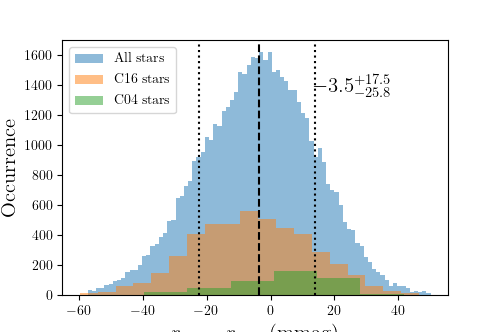

Text(0.5, 0, '$r_{obs}-r_{com}$ (mmag)')

In [434]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int((np.nanmax(diff[m]) - np.nanmin(diff[m])) /(2*iqr(diff[m])*len(diff[m])**(-1/3)))
a = plt.hist(diff[m]*1e3,bins=b, alpha=0.5,label='All stars')
#plt.axvspan(low,high,alpha = .3,color='orange')

b = int(np.nanmax(diff16[m16]) - np.nanmin(diff16[m16]) /(2*iqr(diff16[m16])*len(diff16[m16])**(-1/3)))
a = plt.hist(diff16[m16]*1e3,bins=b, alpha=0.5,label='C16 stars')

b = int(np.nanmax(diff4[m4]) - np.nanmin(diff4[m4]) /(2*iqr(diff4[m4])*len(diff4[m4])**(-1/3)))
a = plt.hist(diff4[m4]*1e3,bins=b, alpha=0.5,label='C04 stars')

med = np.percentile(diff[m]*1e3,50)
low = np.percentile(diff[m]*1e3,16)
high = np.percentile(diff[m]*1e3,84)


plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,1))+'^{+' + str(np.round(high-med,1))+'}_{'+str(np.round(low+med,1))+'}$'
plt.annotate(s,(.65,.8),fontsize=15,xycoords='axes fraction')

plt.legend(loc=2)
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=15)
#plt.savefig('robs-rcom.pdf', bbox_inches = "tight")

In [413]:
from dustmaps.sfd import SFDQuery
from dustmaps.planck import PlanckQuery
from dustmaps.bayestar import BayestarQuery

In [426]:
coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg,
                  distance=(d16.gaia_med.values*0+200)*u.pc, frame='icrs')

sfd = SFDQuery()
Av_sfd =  sfd(coords)
#planck = PlanckQuery()
#Av_planck = 3.1 * planck(coords)
bayestar = BayestarQuery(max_samples=1)
Av_bayestar = bayestar(coords)


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.524 s
  pix_info:   0.609 s
   samples:   5.513 s
      best:   5.203 s
       nan:   0.043 s
      sort:   7.991 s
       idx:   0.166 s


In [437]:
ra = np.arange(np.nanmin(d16.RAJ2000)-.5,np.nanmax(d16.RAJ2000)+.5,.01)
dec = np.arange(np.nanmin(d16.DecJ2000)+.1,np.nanmax(d16.DecJ2000)-.1,.01)
ra, dec = np.meshgrid(ra, dec)
coords = SkyCoord(ra*u.deg, dec*u.deg)

bayestar = BayestarQuery(max_samples=1)
red = bayestar(coords)

sfd = SFDQuery()
Av_sfd =  sfd(coords)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.555 s
  pix_info:   0.611 s
   samples:   5.235 s
      best:   5.400 s
       nan:   0.043 s
      sort:   8.096 s
       idx:   0.171 s


<IPython.core.display.Javascript object>


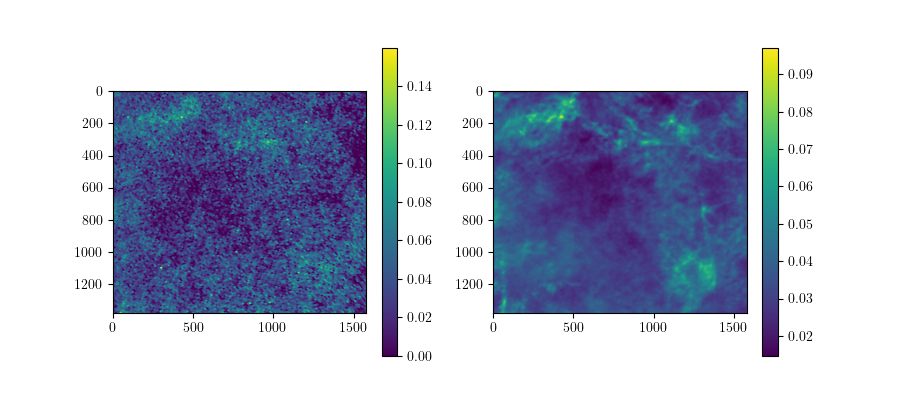

In [442]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(red[:,:,-1])
plt.colorbar()
plt.subplot(122)
plt.imshow(Av_sfd)
plt.colorbar()

In [280]:
def ext_min(factor,b19,slr):
    return np.nansum(abs(b19*factor-slr))


<IPython.core.display.Javascript object>


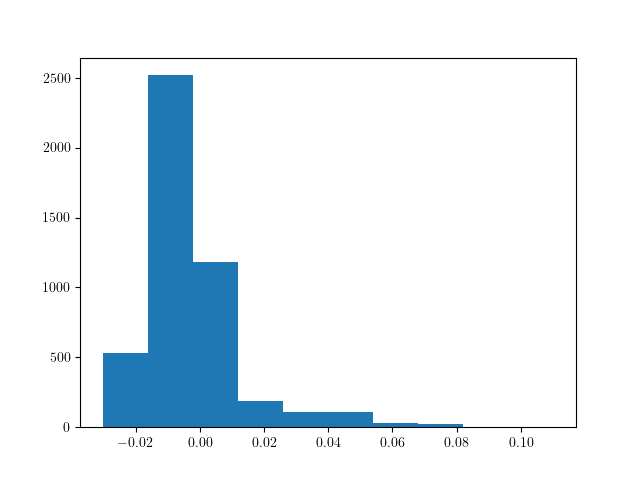

(array([5.340e+02, 2.518e+03, 1.185e+03, 1.900e+02, 1.120e+02, 1.070e+02,
        2.800e+01, 2.600e+01, 2.000e+00, 2.000e+00]),
 array([-0.0303514 , -0.01629948, -0.00224756,  0.01180436,  0.02585628,
         0.0399082 ,  0.05396012,  0.06801204,  0.08206396,  0.09611588,
         0.1101678 ]),
 <BarContainer object of 10 artists>)

In [431]:
plt.figure()
plt.hist(Av_bayestar-med162)

In [276]:
from scipy.optimize import minimize

In [289]:
scale = minimize(ext_min,0.1,args=(medall,medall2),method='Nelder-Mead').x

In [304]:
med16

array([0.09, 0.03, 0.03, ..., 0.04, 0.04, 0.07], dtype=float32)

In [305]:
med162

array([0.00010826, 0.00010826, 0.00010826, ..., 0.01286408, 0.0102971 ,
       0.0102971 ])

In [205]:
R = {'g': {'coeff': [-0.13124379,  3.62895124],
	  'std': 0.0020887812058893386},
	 'r': {'coeff': [-0.05341101,  2.61050894],
	  'std': 0.0014051411128491614},
	 'i': {'coeff': [-0.02078397,  1.93460086],
	  'std': 0.0007876188357844897},
	 'z': {'coeff': [-0.00844383,  1.52472518],
	  'std': 0.0016408304442729969},
	 'y': {'coeff': [-0.00552816,  1.27382894],
	  'std': 0.0006275927170022182},
	 'kep': {'coeff': [-0.39528065,  2.55730023],
	  'std': 0.009144735545814015},
	 'tess': {'coeff': [-0.16614288,  1.84626759],
	  'std': 0.011591550711318106}}

def line(x, c1, c2): 
    return c1*x + c2

def R_val(band,g=None,r=None,gr=None,ext=0):
    if (g is not None) & (r is not None):
        gr = g-r

    if (gr is None) | np.isnan(gr).all():
            Rb   = R[band]['coeff'][1]
    else:
        Rr0 = R[band]['coeff'][1]
        Rg0 = R[band]['coeff'][1]

        gr_int = gr - ext*(Rg0 - Rr0)

        vals = R[band]['coeff']
        Rb  = line(gr_int,vals[0],vals[1])
    Rb_e = R[band]['std']

    return Rb, Rb_e

In [198]:
from R_load import R_val

In [207]:
r, re = R_val('r',g=c16['g'],r=c16['r'],ext=med16)

In [208]:
r - 2.61050894

array([-0.03851957, -0.04222633, -0.03008603, ..., -0.02688134,
       -0.02754897, -0.04235449])

In [79]:
med16*10

array([0.9       , 0.29999998, 0.29999998, ..., 0.39999998, 0.39999998,
       0.7       ], dtype=float32)

<IPython.core.display.Javascript object>


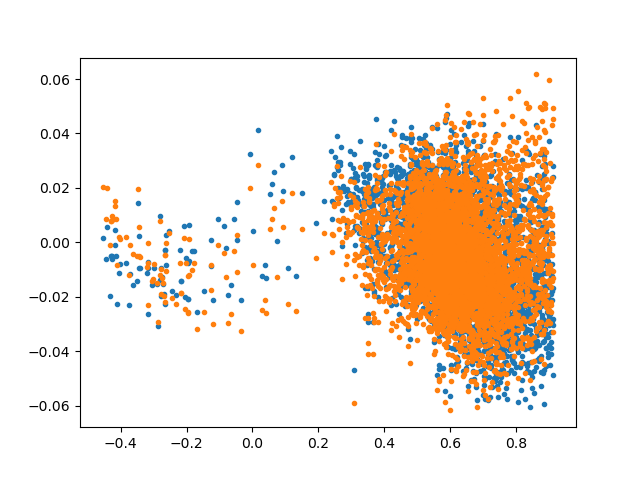

In [282]:
test = r_comp(res.x,c16,med16)
test2 = r_comp(res2.x,c16,med16)
diff16 = (c16['r']-test)#*1e3
diff162 = (c16['r']-test2)#*1e3
m16 = ~sigma_clip(diff16).mask

plt.figure()
plt.plot((c16['g']-c16['r'])[m16],diff16[m16],'.')
plt.plot((c16['g']-c16['r'])[m16],diff162[m16],'.')

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


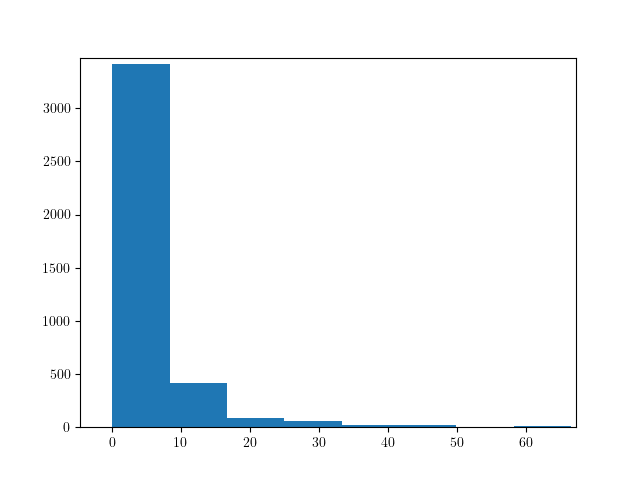

(array([3.416e+03, 4.140e+02, 9.100e+01, 6.000e+01, 1.800e+01, 2.000e+01,
        4.000e+00, 1.300e+01, 0.000e+00, 6.000e+00, 0.000e+00, 1.000e+01,
        0.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.200e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

In [303]:
eh =(med16/med162)
plt.figure()
plt.hist(eh[np.isfinite(eh)],bins=100)

<IPython.core.display.Javascript object>


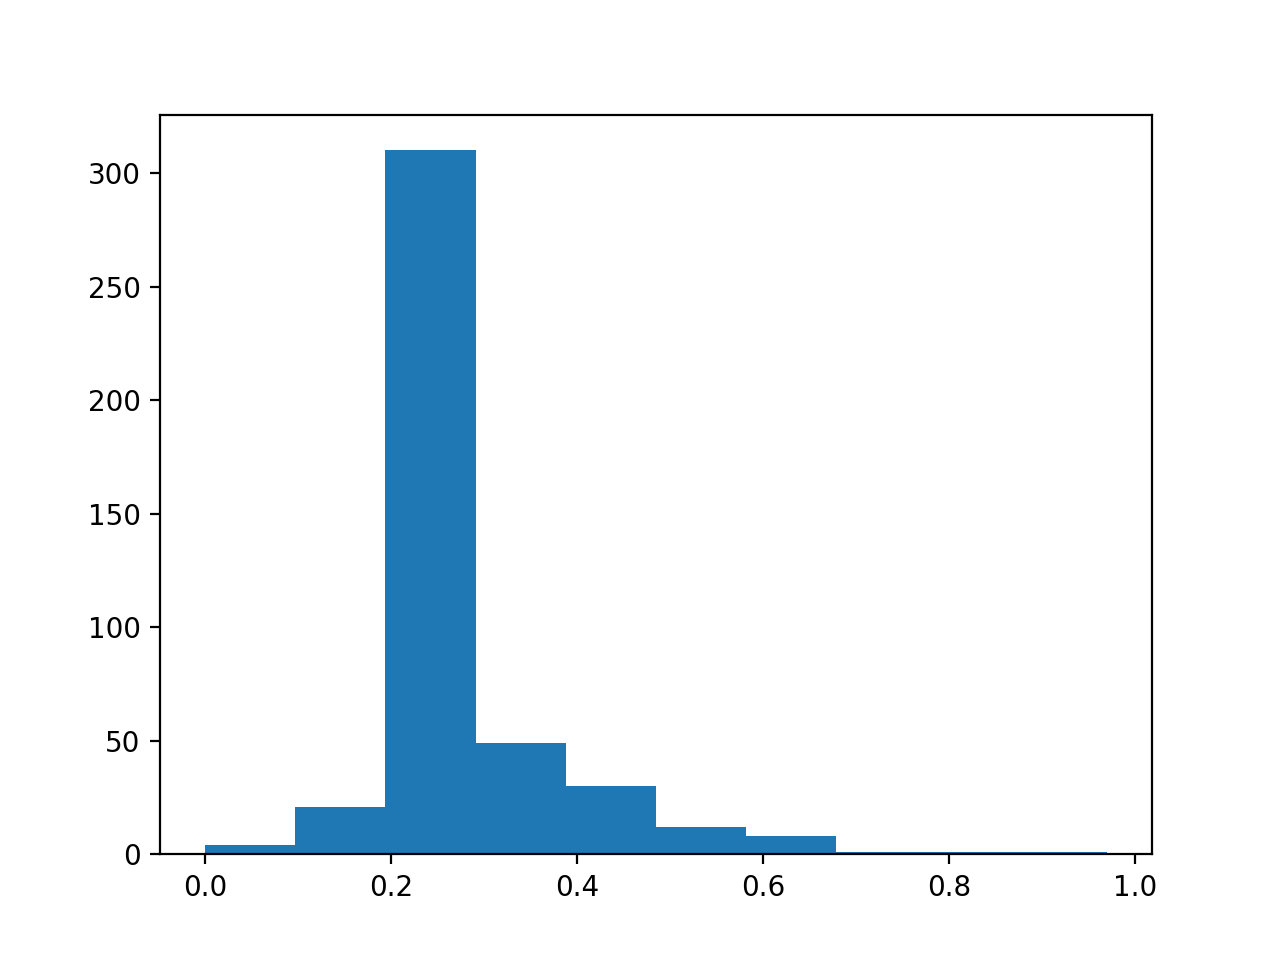

(array([  4.,  21., 310.,  49.,  30.,  12.,   8.,   1.,   1.,   1.]),
 array([0.        , 0.097     , 0.19399999, 0.29099998, 0.38799998,
        0.48499998, 0.58199996, 0.67899996, 0.77599996, 0.87299997,
        0.96999997], dtype=float32),
 <BarContainer object of 10 artists>)

In [140]:
plt.figure()
plt.hist(med4)

# fit to PS1 obs data

In [82]:
c0 = [.3,.3,.3,1]
bds = [(0,1),(0,1),(0,1),(-100,100)]
res2 = minimize(r_minimizer,c0,args=(c16,med16),bounds=bds)

In [68]:
res.x

array([0.05219065, 0.99862204, 0.        , 0.31264066])

In [69]:
res2.x

array([0.12786611, 0.91611482, 0.        , 0.24280886])

In [93]:
data = r_comp(res2.x,c16,ext=med16)
#data2 = r_linear_combo2(res22.x,c16)
cal = r_comp(res.x,c16,ext=med16)

In [94]:
diff = (c16['r']-cal) * 1e3
diff2 = (c16['r']-data) * 1e3
#diff22 = c16['r']-data2
m = ~sigma_clip(diff2).mask & ~sigma_clip(diff).mask

<IPython.core.display.Javascript object>


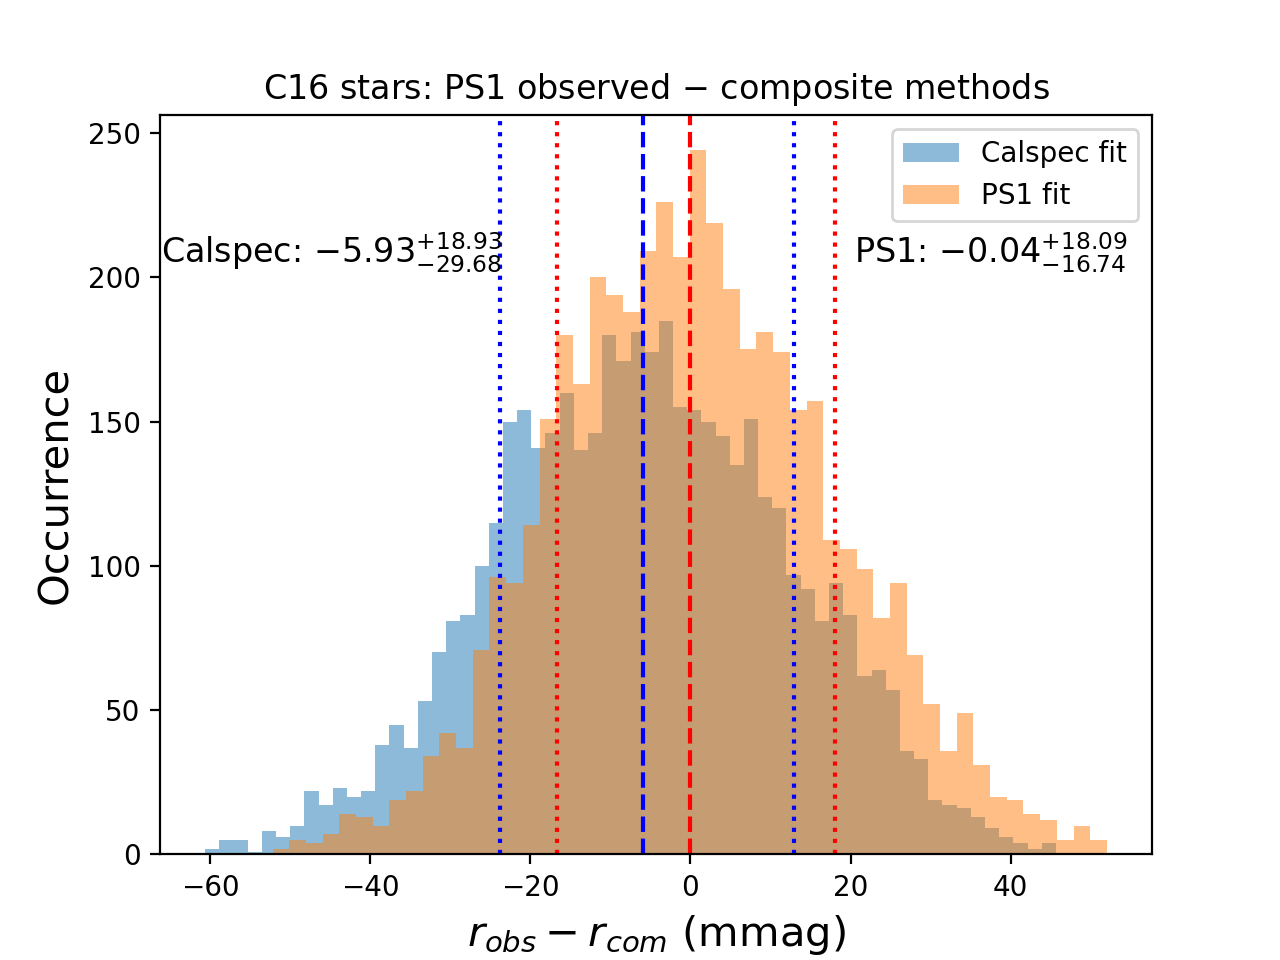

In [95]:
plt.figure()
plt.hist(diff[m],bins=60,alpha=.5,label='Calspec fit');
med = np.percentile(diff[m],50)
low = np.percentile(diff[m],16)
high = np.percentile(diff[m],84)

plt.axvline(med,ls='--',color='b')
plt.axvline(low,ls=':',color='b')
plt.axvline(high,ls=':',color='b')

s = 'Calspec: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(0.001,.8),fontsize=12,xycoords='axes fraction')

plt.hist(diff2[m],bins=50,alpha=.5,label='PS1 fit');
med = np.percentile(diff2[m],50)
low = np.percentile(diff2[m],16)
high = np.percentile(diff2[m],84)

plt.axvline(med,ls='--',color='r')
plt.axvline(low,ls=':',color='r')
plt.axvline(high,ls=':',color='r')

s = 'PS1: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.7,.8),fontsize=12,xycoords='axes fraction')


#plt.hist(diff22[m],bins=100,alpha=.5,label='PS1 observed');
plt.legend()
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=15)
plt.title('C16 stars: PS1 observed $-$ composite methods')
plt.savefig('calspecfit_vs_ps1datafit.png')

In [159]:
calmed

array([0.08      , 0.        ,        nan,        nan, 0.06      ,
              nan, 0.05      , 0.04      , 0.05      , 0.06      ,
       0.04      , 0.05      ,        nan,        nan, 0.00916754,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.03      , 0.        ,
       0.        , 0.        ,        nan,        nan, 0.03      ,
       0.        , 0.        ,        nan, 0.        , 0.        ,
              nan,        nan, 0.04      ,        nan, 0.        ,
       0.        ,        nan, 0.        , 0.04695679,        nan,
              nan, 0.        ,        nan,        nan,        nan,
       0.        , 0.        , 0.        , 0.        , 0.        ,
              nan,        nan, 0.        ,        nan,        nan,
       0.08      ,        nan,        nan,        nan,        nan,
       0.12      , 0.        , 0.        ,        nan,        nan,
       0.        , 0.07      , 0.05      , 0.        , 0.     

In [160]:
calsources

,name,type,V,V-B,filename,model,STIS,FOS+Oke,IUE+Oke,ra,dec,id,gaia_med,gaia_low,gaia_high
0,10 Lac,O9V,4.88,-0.21,10lac,_mod_003,_stis_005,NaN,NaN,339.815329,39.050269,0,358.606583,330.334841,392.066648
1,109 Vir,A0III,3.73,-0.01,109vir,_mod_002,_stis_002,NaN,NaN,221.562187,1.892883,1,39.751606,39.169532,40.350924
2,16 Cyg B,G3V,6.2,0.66,16cygb,_mod_002,_stis_002,NaN,NaN,295.466554,50.517525,2,NaN,NaN,NaN
3,18 Sco,G2V,5.5,0.65,18sco,_mod_002,_stis_002,NaN,NaN,243.905292,-8.369439,3,NaN,NaN,NaN
4,1732526,A4V,12.53,0.12,1732526,_mod_003,_stisnic_005,NaN,NaN,263.219292,71.078644,4,1119.293953,1082.212204,1158.952324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,LTT9491,DB3,14.1,0.03,ltt9491,NaN,NaN,NaN,_002,349.897450,-17.091242,119,NaN,NaN,NaN
120,NGC7293,DAO.5,13.52,-0.36,ngc7293,NaN,NaN,NaN,_005,337.410604,-20.837153,120,199.879387,196.853253,202.998293
121,SNAP-1,sdB,15.4,0.2,snap1,NaN,_stisnic_007,NaN,NaN,247.398946,52.931558,121,2063.001523,1883.442522,2278.376162
122,SUN,G2V,-26.75,0.63,sun_reference,NaN,_stis_002*,NaN,NaN,NaN,NaN,122,NaN,NaN,NaN


In [121]:
def fit_cal_correction(x,fit,data,ext):
    d = deepcopy(data)
    d['g'] += x[0]
    d['i'] += x[1]
    d['z'] += x[2]
    res = r_minimizer(fit,d,ext)
    print(res)
    return res

In [123]:
c0 = [0,0,0]
bds = [(0,2),(0,2),(0,2)]
corfit = minimize(fit_cal_correction,c0,args=(res.x,c16,med16),method='Nelder-Mead')#,bounds=bds)

832.7286527144108
833.1200210147933
833.5082787351722
832.7286527144108
832.2099300607456
831.5607405839742
831.5586876814602
830.7780210147923
830.6496222324674
829.6102694805504
828.5711686636946
826.4929367977518
826.3605585512826
823.7607784702328
822.4648022008708
818.3081069343086
816.0974748043949
809.3407003360115
807.7800336693435
798.4230397780134
793.6189687407829
778.5455260617905
772.5634369166296
749.6901673772154
741.7654341861647
707.979617709517
692.3851811501952
639.3490952469044
619.4578571731507
539.9066597790898
508.4494731758624
387.983844456131
337.0577224123642
155.47822864094147
102.33192019279538
224.261651497387
155.3090922942063
342.5335728405518
168.7794357397427
212.44645780177933
99.75925632725678
242.81608204699717
92.18341544458531
186.0290781768719
97.56288169247712
139.83238752637834
84.20033059901925
103.25419177738199
86.2249835800852
112.86786242849385
84.52652249469922
102.6090269258776
83.5914686940579
89.84113948484918
82.6544970314554
89.963849

In [124]:
corfit

 final_simplex: (array([[-0.03809729, -0.24462051,  0.09723285],
       [-0.03809479, -0.24461391,  0.09723   ],
       [-0.03810273, -0.24466243,  0.09724947],
       [-0.03810423, -0.24467441,  0.09725248]]), array([81.95167684, 81.95168653, 81.95170599, 81.95174464]))
           fun: 81.9516768414251
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 50
        status: 0
       success: True
             x: array([-0.03809729, -0.24462051,  0.09723285])

In [105]:
corrections

array([-0.029354, -0.015662, -0.009571, -0.005817])

In [7]:
pos = res.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=([syn]))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/rridden/miniconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:03<00:00, 1612.20it/s]


In [164]:
var = res.x
pos = var + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape
nsteps = 10000#2000
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=([syn]), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/rridden/miniconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:59<00:00, 168.92it/s]


<IPython.core.display.Javascript object>


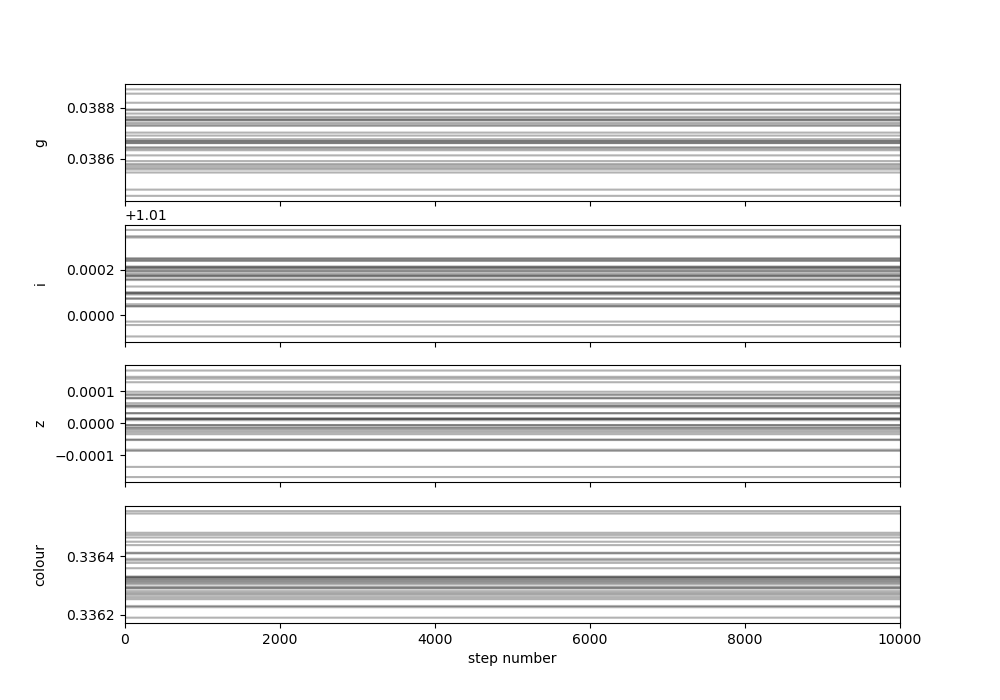

In [165]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["g", "i","z","colour"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(19200, 4)


<IPython.core.display.Javascript object>


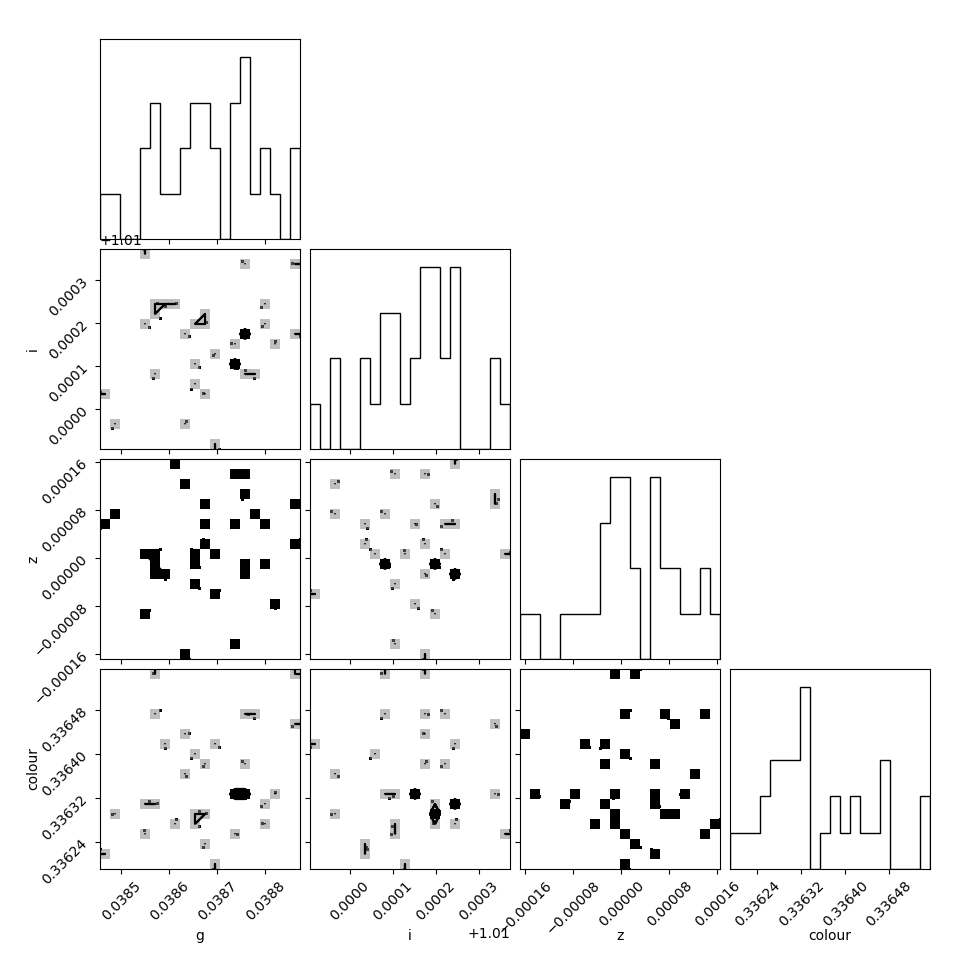

In [166]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [161]:
cg = np.percentile(flat_samples[:, 0],50)
ci = np.percentile(flat_samples[:, 1],50)
cz = np.percentile(flat_samples[:, 2],50)
ccol = np.percentile(flat_samples[:, 3],50)#np.percentile(flat_samples[:, 3],50)

In [162]:
from IPython.display import display, Math


for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [163]:
mc = [cg,ci,cz,ccol]